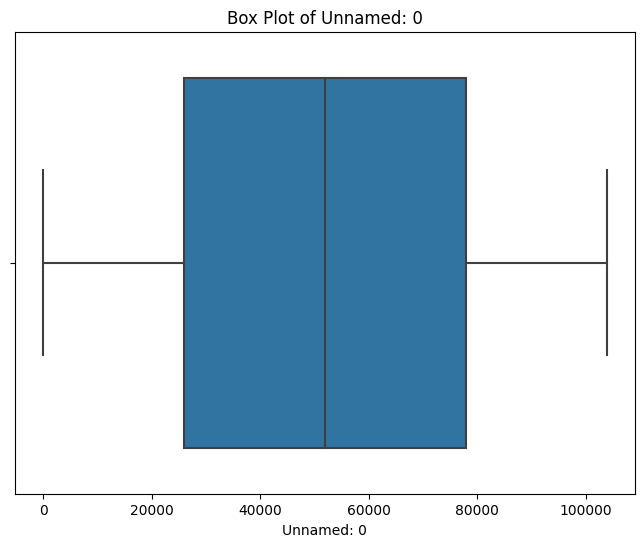

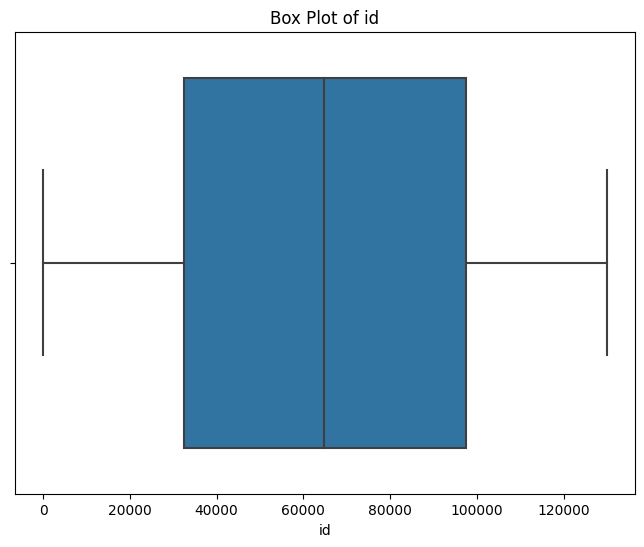

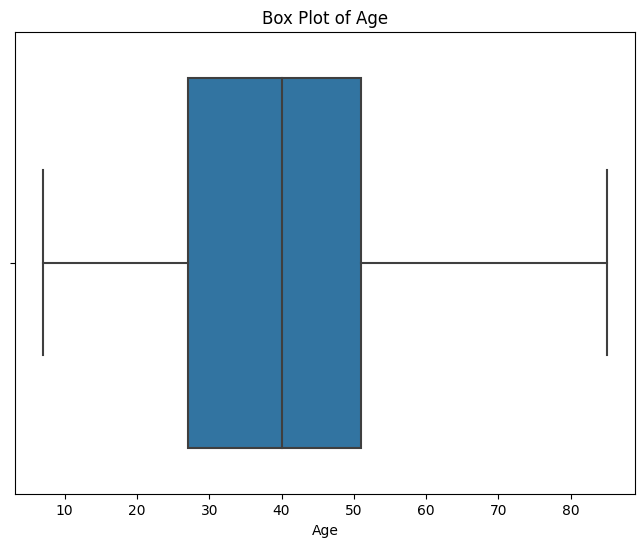

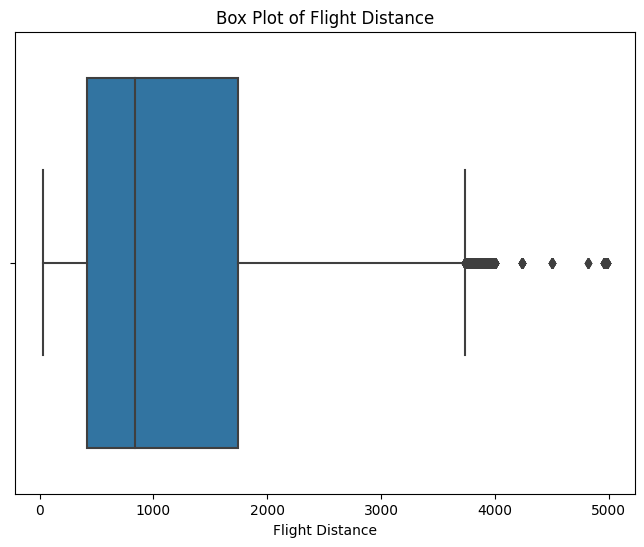

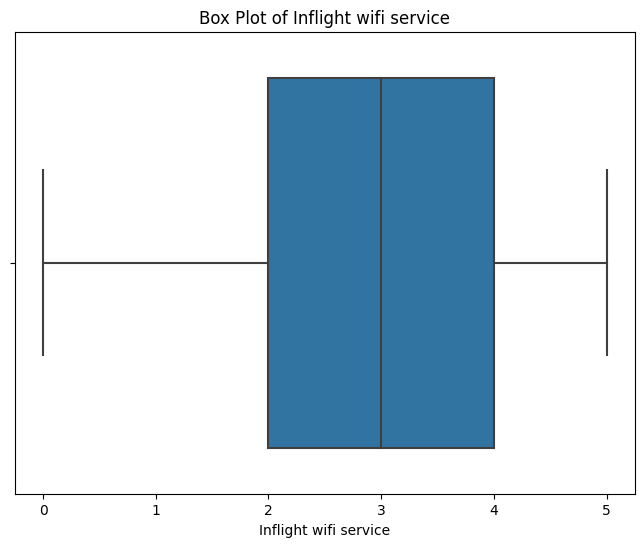

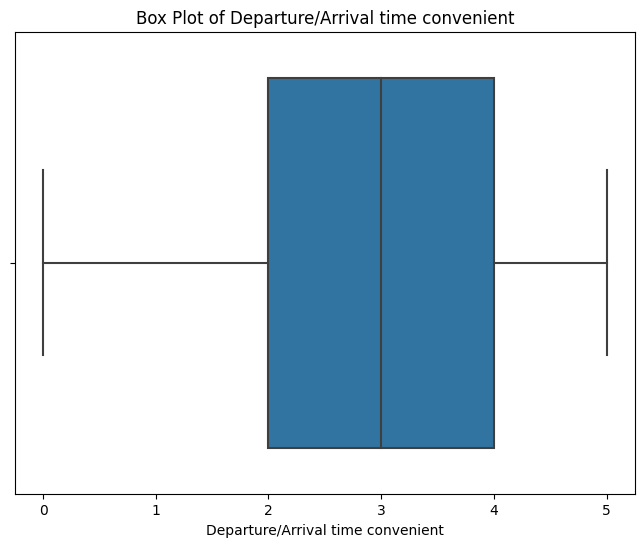

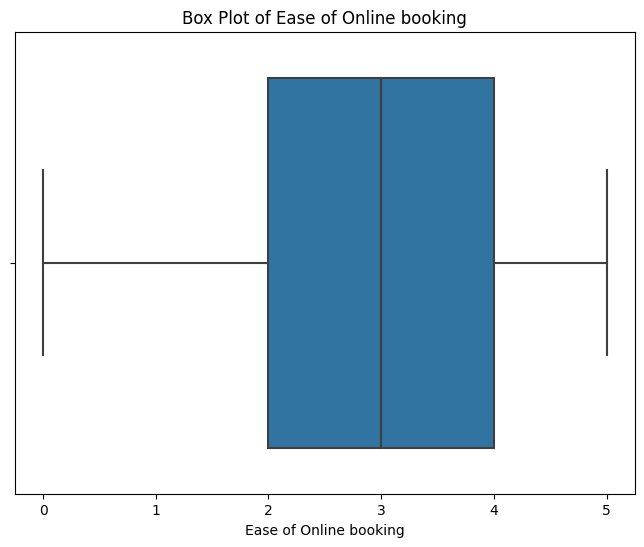

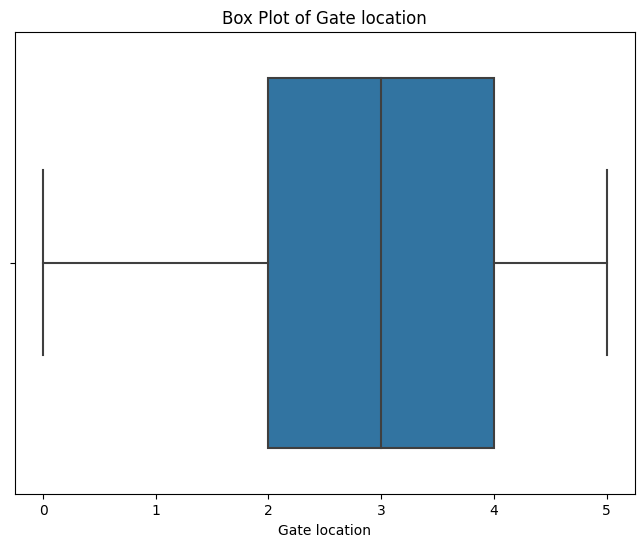

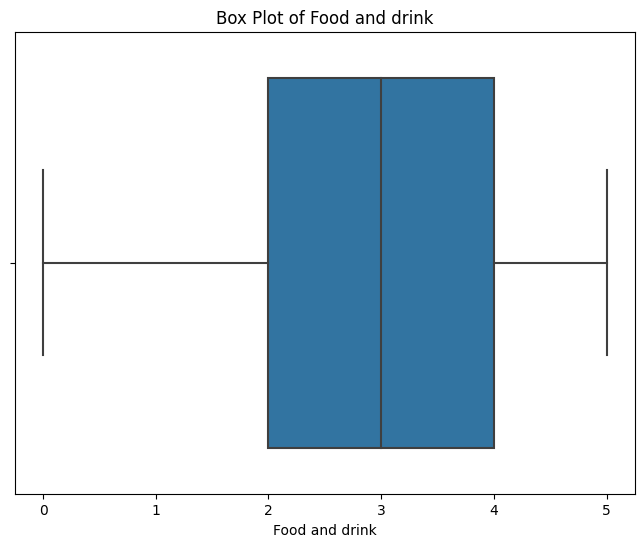

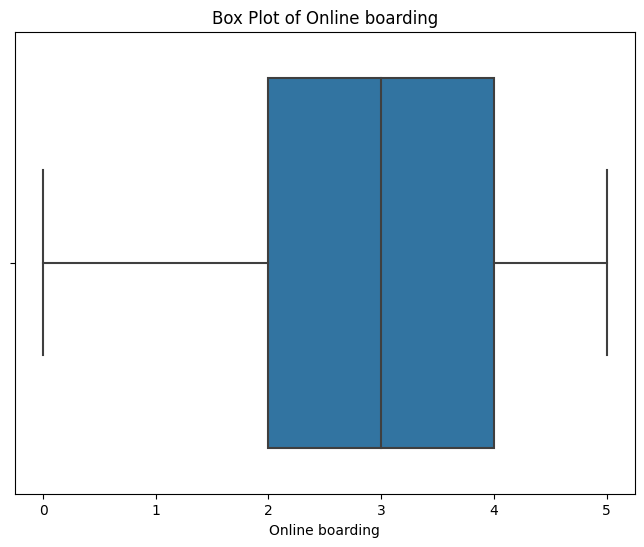

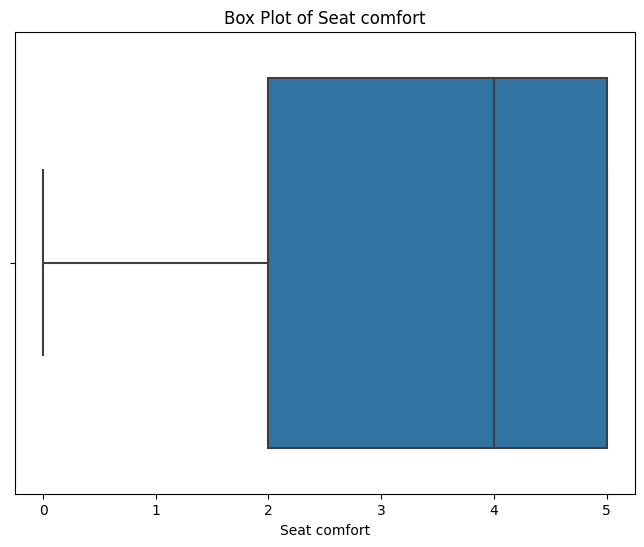

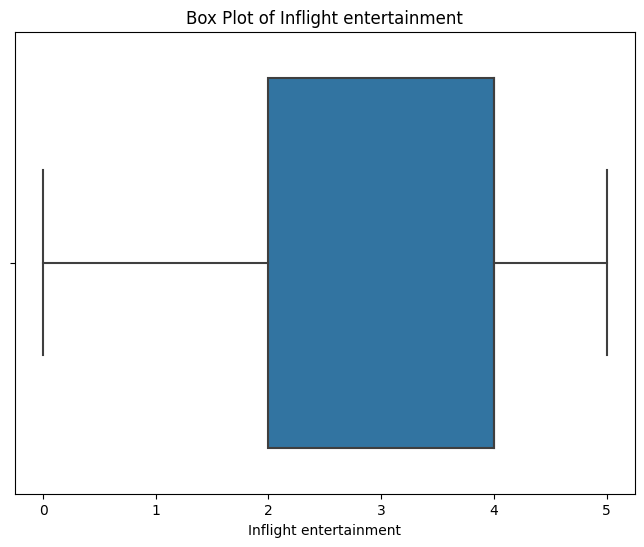

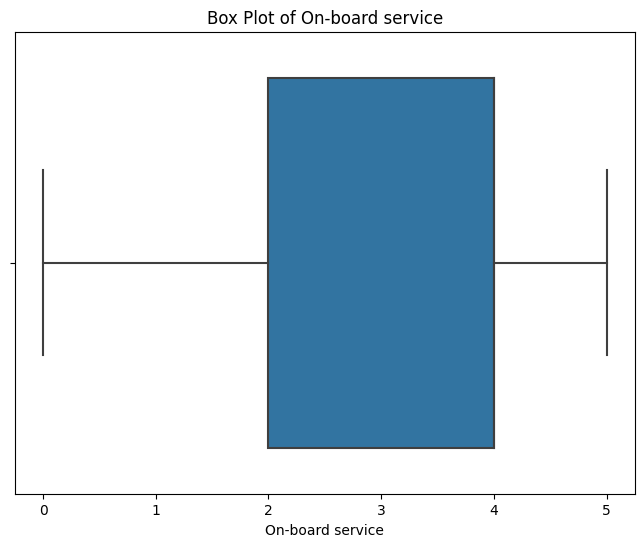

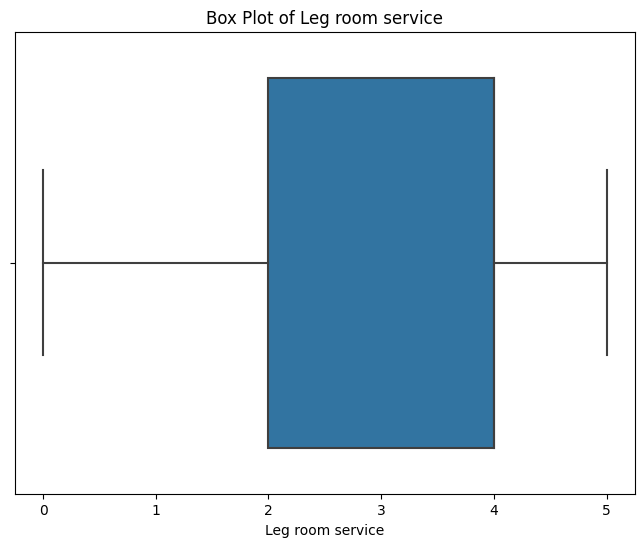

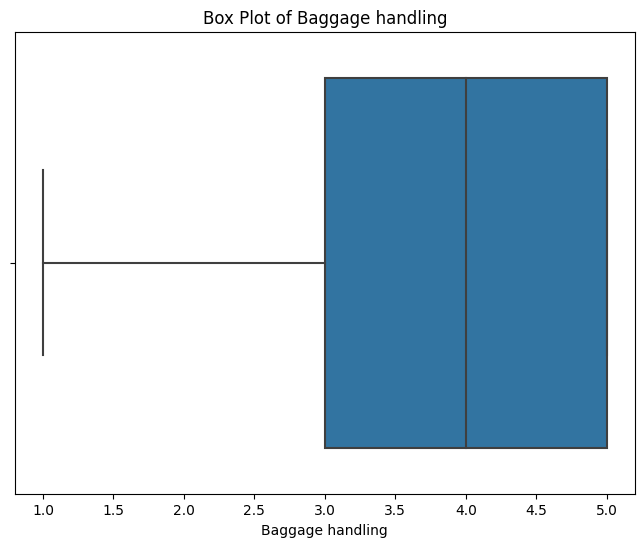

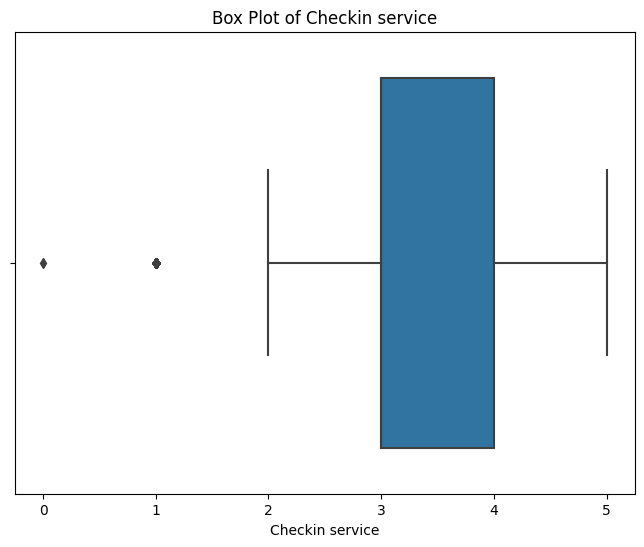

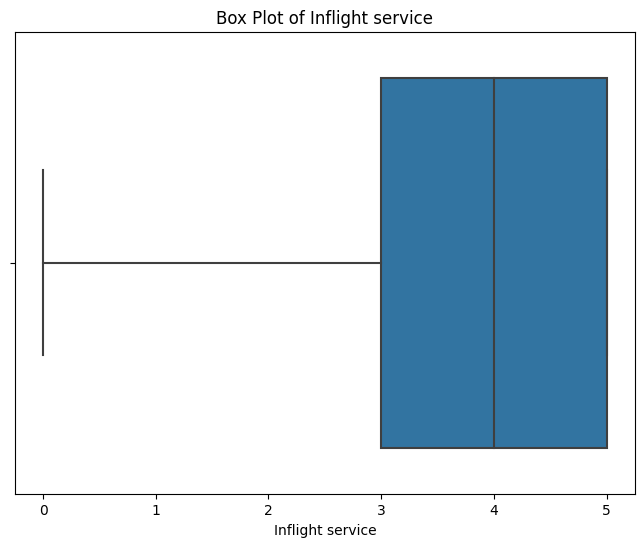

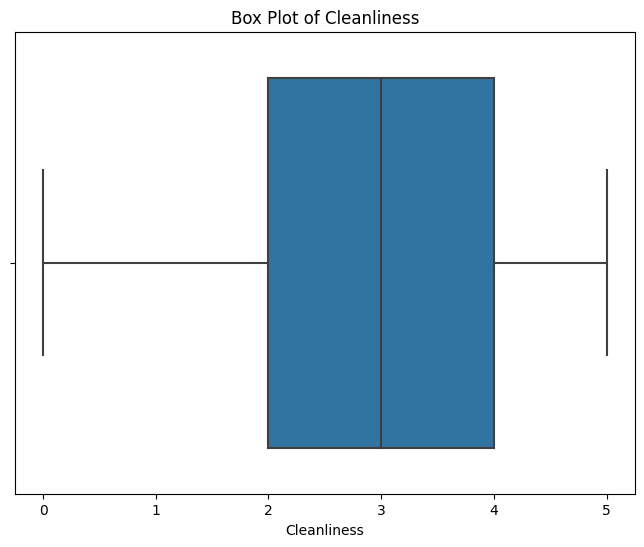

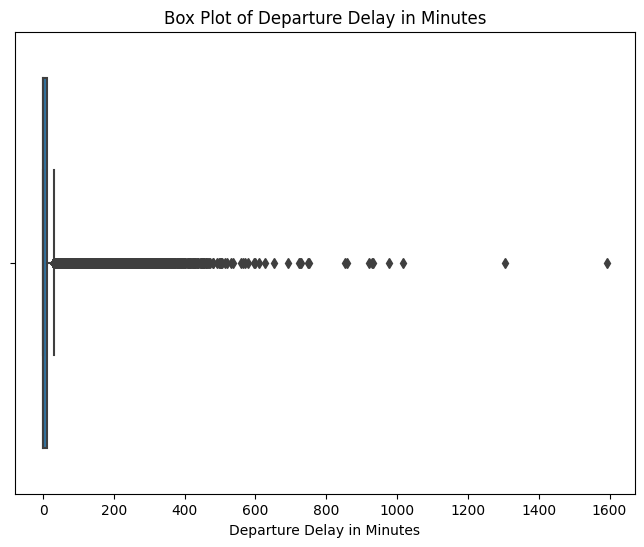

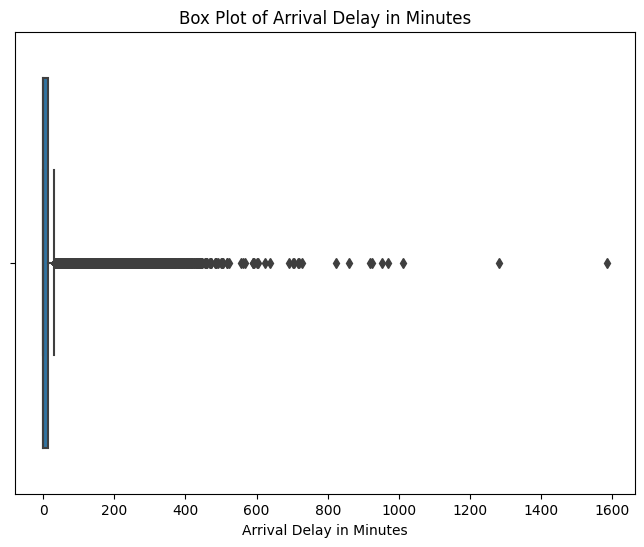

   Unnamed: 0      id  Age  Flight Distance  Inflight wifi service  \
0           0   70172   13            460.0                      3   
1           1    5047   25            235.0                      3   
2           2  110028   26           1142.0                      2   
3           3   24026   25            562.0                      2   
4           4  119299   61            214.0                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                  4                       3              1   
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  ...  contentment  Gender_Female  \
0               5                

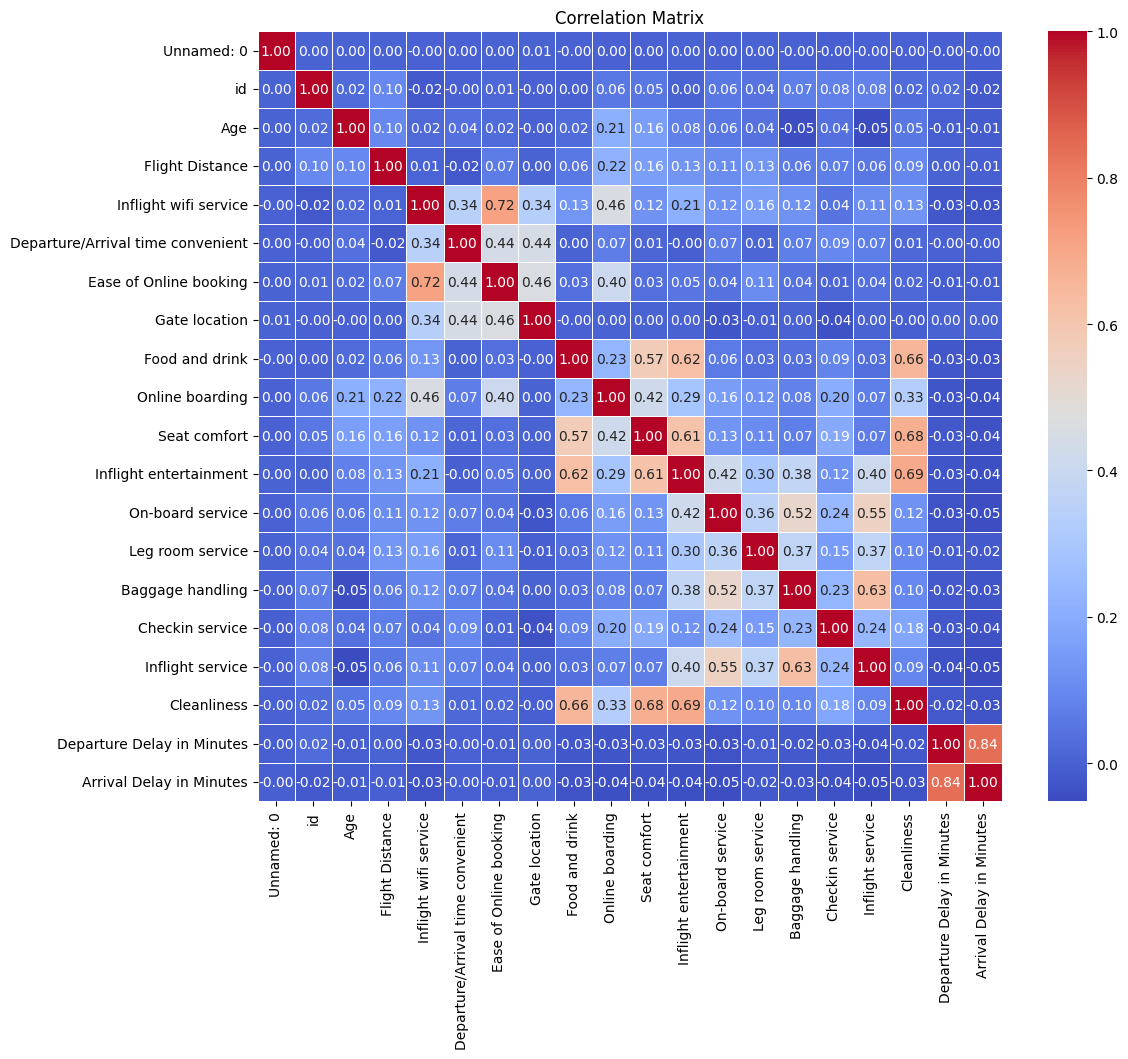

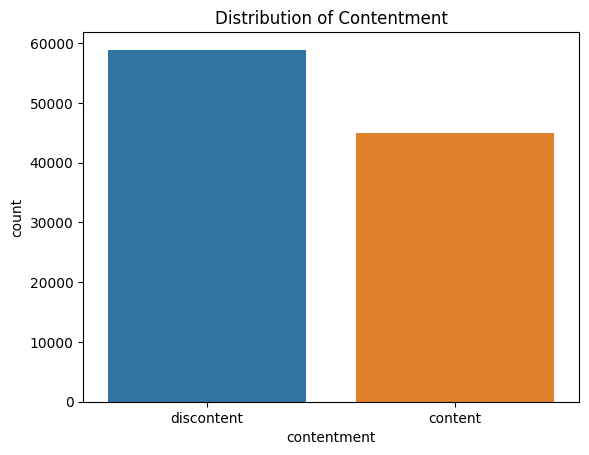

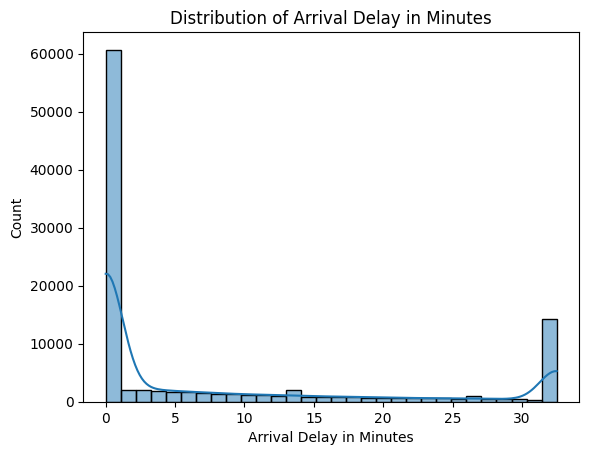

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.optimizers import Nadam
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Read and preprocess data
def preprocess_data(data):
    # Impute NaN values using median
    imputer = SimpleImputer(strategy='median')
    data['Arrival Delay in Minutes'] = imputer.fit_transform(data[['Arrival Delay in Minutes']])

train_data = pd.read_csv('/kaggle/input/testtrain2/train.csv')
test_data = pd.read_csv('/kaggle/input/testtrain2/test.csv')

# Preprocess data
preprocess_data(train_data)
preprocess_data(test_data)

train_data = pd.get_dummies(train_data, columns=["Gender", "Traveler Type", "Type of Travel", "Class"])
test_data = pd.get_dummies(test_data, columns=["Gender", "Traveler Type", "Type of Travel", "Class"])

# EDA: Box Plots for Numeric Features
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train_data, x=feature)
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)
    plt.show()

# Outlier Removal
class OutlierRemoval:
    def __init__(self, lower_limit, upper_limit):
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit

    def remove(self, row):
        if row <= self.upper_limit and row >= self.lower_limit:
            return row
        elif row < self.lower_limit:
            return self.lower_limit
        else:
            return self.upper_limit

# Apply outlier removal to all numeric features
for feature in train_data.columns:
    if train_data[feature].dtype in ['int64', 'float64']:
        lower_limit = train_data[feature].quantile(0.25) - (train_data[feature].quantile(0.75) - train_data[feature].quantile(0.25)) * 1.5
        upper_limit = train_data[feature].quantile(0.75) + (train_data[feature].quantile(0.75) - train_data[feature].quantile(0.25)) * 1.5
        remover = OutlierRemoval(lower_limit, upper_limit)
        train_data[feature] = [remover.remove(x) for x in train_data[feature]]
        
# Apply outlier removal to all numeric features in the testing data
for feature in test_data.drop(columns=["id"]).columns:
    if test_data[feature].dtype in ['int64', 'float64']:
        lower_limit = test_data[feature].quantile(0.25) - (test_data[feature].quantile(0.75) - test_data[feature].quantile(0.25)) * 1.5
        upper_limit = test_data[feature].quantile(0.75) + (test_data[feature].quantile(0.75) - test_data[feature].quantile(0.25)) * 1.5
        remover = OutlierRemoval(lower_limit, upper_limit)
        test_data[feature] = [remover.remove(x) for x in test_data[feature]]

# EDA
# Step 1: Data Loading and Initial Exploration
print(train_data.head())
print(test_data.head())
print(train_data.describe())
print(train_data.info())

# Step 2: Missing Values Analysis
print(train_data.isnull().sum())
print(test_data.isnull().sum())

# Step 3: Correlation Analysis (excluding non-numeric columns)
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
correlation_matrix = train_data[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Step 4: Target Variable Distribution
sns.countplot(x='contentment', data=train_data)
plt.title('Distribution of Contentment')
plt.show()

# Step 5: Feature Distribution
sns.histplot(train_data['Arrival Delay in Minutes'], bins=30, kde=True)
plt.title('Distribution of Arrival Delay in Minutes')
plt.show()



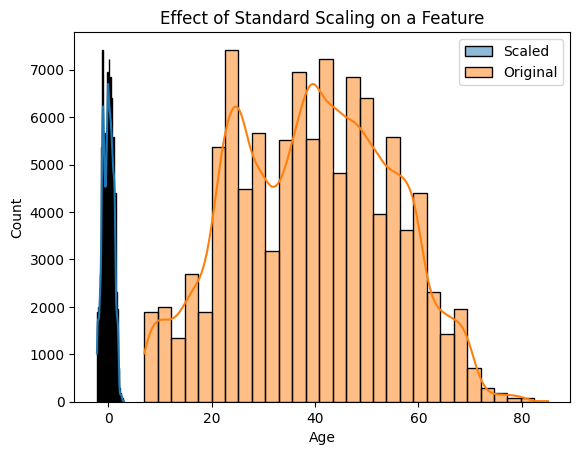

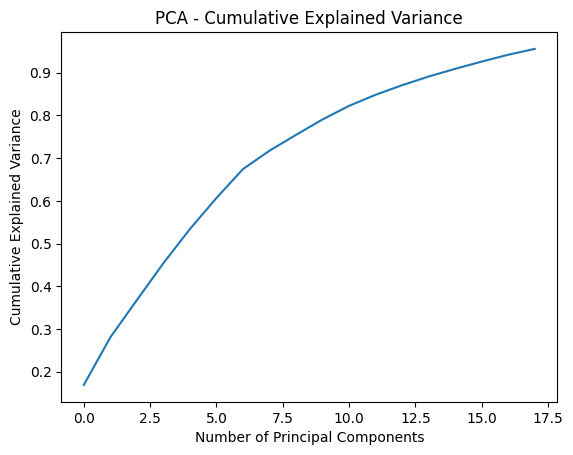

In [38]:
# Split the data into training and validation sets
X_train_data = train_data.drop('contentment', axis=1)
X_train_data = pd.get_dummies(X_train_data)
Y_train_data = pd.get_dummies(train_data['contentment'], drop_first=True)

X_train_data = X_train_data.iloc[:, 2:]
X_test_data = pd.get_dummies(test_data).iloc[:, 2:]

# Step 6: Scaling and PCA Effects
data_scaler = StandardScaler()
X_train_data_scaled = data_scaler.fit_transform(X_train_data)
sns.histplot(X_train_data_scaled[:, 0], bins=30, kde=True, label='Scaled')
sns.histplot(X_train_data.iloc[:, 0], bins=30, kde=True, label='Original')
plt.title('Effect of Standard Scaling on a Feature')
plt.legend()
plt.show()

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.show()



In [ ]:
# Standard Scaling
data_scaler = StandardScaler()
X_train_data_scaled = data_scaler.fit_transform(X_train_data)
X_test_data_scaled = data_scaler.transform(X_test_data)

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_data_scaled)
X_test_pca = pca.transform(X_test_data_scaled)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_pca, Y_train_data, test_size=0.1, random_state=42)

# Define a dictionary to store model performances
model_scores = {}

# Support Vector Machine (SVM)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, Y_train)
y_pred_svm = svm_model.predict(X_val)
accuracy_svm = accuracy_score(Y_val, y_pred_svm)
model_scores['SVM'] = accuracy_svm
print(accuracy_svm)

# Nu-Support Vector Machine (NuSVM)
nusvm_model = NuSVC(nu=0.5, kernel='rbf', gamma='scale', random_state=42)
nusvm_model.fit(X_train, Y_train)
y_pred_nusvm = nusvm_model.predict(X_val)
accuracy_nusvm = accuracy_score(Y_val, y_pred_nusvm)
model_scores['NuSVM'] = accuracy_nusvm
print(accuracy_nusvm)

# Multi-Layer Perceptron (MLPClassifier)
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(X_train, Y_train)
y_pred_mlp = mlp_model.predict(X_val)
accuracy_mlp = accuracy_score(Y_val, y_pred_mlp)
model_scores['MLP'] = accuracy_mlp
print(accuracy_mlp)

# Boosting using AdaBoost with Decision Trees
base_model = DecisionTreeClassifier(criterion='entropy', max_depth=None)
adaboost_model = AdaBoostClassifier(base_estimator=base_model, n_estimators=100, random_state=42)
adaboost_model.fit(X_train, Y_train)
y_pred_ada = adaboost_model.predict(X_val)
accuracy_ada = accuracy_score(Y_val, y_pred_ada)
model_scores['AdaBoost'] = accuracy_ada
print(accuracy_ada)

# Bagging using Decision Trees
bag_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, oob_score=True, random_state=42)
bag_model.fit(X_train, Y_train)
y_pred_bag = bag_model.predict(X_val)
accuracy_bag = accuracy_score(Y_val, y_pred_bag)
model_scores['Bagging'] = accuracy_bag
print(accuracy_bag)

# Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
clf_rf.fit(X_train, Y_train)
y_pred_rf = clf_rf.predict(X_val)
accuracy_rf = accuracy_score(Y_val, y_pred_rf)
model_scores['RandomForest'] = accuracy_rf
print(accuracy_rf)

# Neural Network Model
model_data = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train_pca.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_data.compile(optimizer=Nadam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model_data.fit(X_train_pca, Y_train_data, epochs=20)

# Get the accuracy on the training data
train_accuracy = model_data.evaluate(X_train_pca, Y_train_data)[1]
print(f"Neural Network Accuracy: {train_accuracy}")



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9412953517467039


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8725820421518622


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
plt.bar(model_scores.keys(), model_scores.values())
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Compare model performances
best_model_name = max(model_scores, key=model_scores.get)
print(f"Best Model: {best_model_name}, Accuracy: {model_scores[best_model_name]}")

# Use the best model for final predictions on the test set
if best_model_name == 'SVM':
    final_predictions = svm_model.predict(X_test_pca)
elif best_model_name == 'NuSVM':
    final_predictions = nusvm_model.predict(X_test_pca)
elif best_model_name == 'MLP':
    final_predictions = mlp_model.predict(X_test_pca)
elif best_model_name == 'AdaBoost':
    final_predictions = adaboost_model.predict(X_test_pca)
elif best_model_name == 'Bagging':
    final_predictions = bag_model.predict(X_test_pca)
elif best_model_name == 'RandomForest':
    final_predictions = clf_rf.predict(X_test_pca)
elif best_model_name == 'NeuralNetwork':
    final_predictions = (model_data.predict(X_test_data_scaled) > 0.5).astype(int)

In [ ]:
# Convert predictions to binary values
predicted_target_data = (final_predictions > 0.5).astype(int)

# Create a DataFrame for the final predictions
result_df = pd.DataFrame({'id': test_data['id'], 'contentment': predicted_target_data.flatten()})

# Define a mapping function to map numeric predictions to 'content' or 'neutral or discontent'
def map_to_contentment(value):
    if value == 0:
        return 'content'
    else:
        return 'neutral or discontent'

# Apply the mapping function to the 'contentment' column
result_df['contentment'] = result_df['contentment'].apply(map_to_contentment)

# Save the DataFrame to a CSV file
result_df.to_csv('predictions.csv', index=False)

# Print the first few rows of the result DataFrame
print(result_df.head())
